# Imports

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score,classification_report, recall_score, precision_score
# ROC curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance
import xgboost as xgb

/home/pelle/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data

In [3]:
p = '/home/pelle/Master_Thesis/data/raw/wallstreetbets/network_features/'
file_names=os.listdir(p)

data = []
for name in file_names:
    data.append(pd.read_csv(p+name))

df_gf=pd.concat(data)
df_balanced = pd.read_csv('/home/pelle/Master_Thesis/data/raw/wallstreetbets/balanced_data_chunked10.csv')

df_gf.drop_duplicates(inplace=True)
df=df_balanced.join(df_gf.set_index('id'),on='id')
df.dropna(subset='degree',inplace=True)
df=df[['author', 'date', 'score', 'n_comments', 'id',
       'n_awards', 'text_title', 'degree_cen',
       	'close_cen','activity',	'degree','N_nodes',
        'N_edges','mentions','frac_rec',	
        'degree_in','degree_out','N_rec_author','N_rec']]

df.loc[df.n_awards==0,'awarded']=0
df.loc[df.n_awards!=0,'awarded']=1

df['n_comments']=df.n_comments.apply(lambda x: np.sqrt(x**2))

df['date'] = pd.to_datetime(df['date'])

# Analysis

In [4]:
df['awarded'].value_counts()

1.0    28231
0.0    28047
Name: awarded, dtype: int64

# graph

In [5]:
feature_translate = {'degree_cen':'Degree Centrality',
                        'close_cen':'Closeness Centrality',
                        'activity':'Activity',
                        'degree':'Degree',
                        'N_nodes':'Number of Nodes',
                        'N_edges':'Number of Edges',
                        'mentions':'Number of Mentions',
                        'frac_rec':'Fraction of Reciprocal Edges',
                        'degree_in':'In Degree',
                        'degree_out':'Out Degree',
                        'N_rec_author':'Number of Reciprocal Edges for the Author',
                        'N_rec':'Number of Reciprocal Edges'}

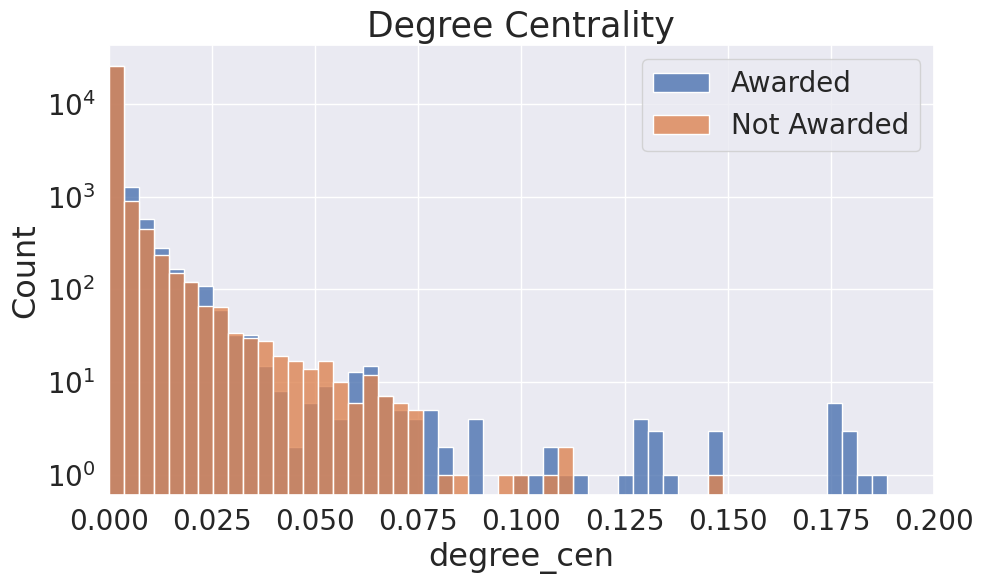

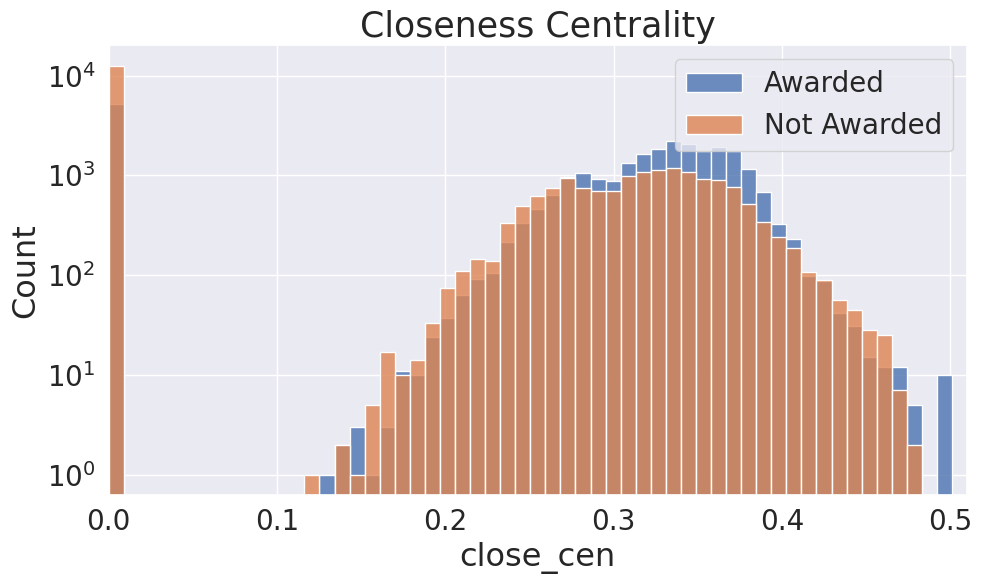

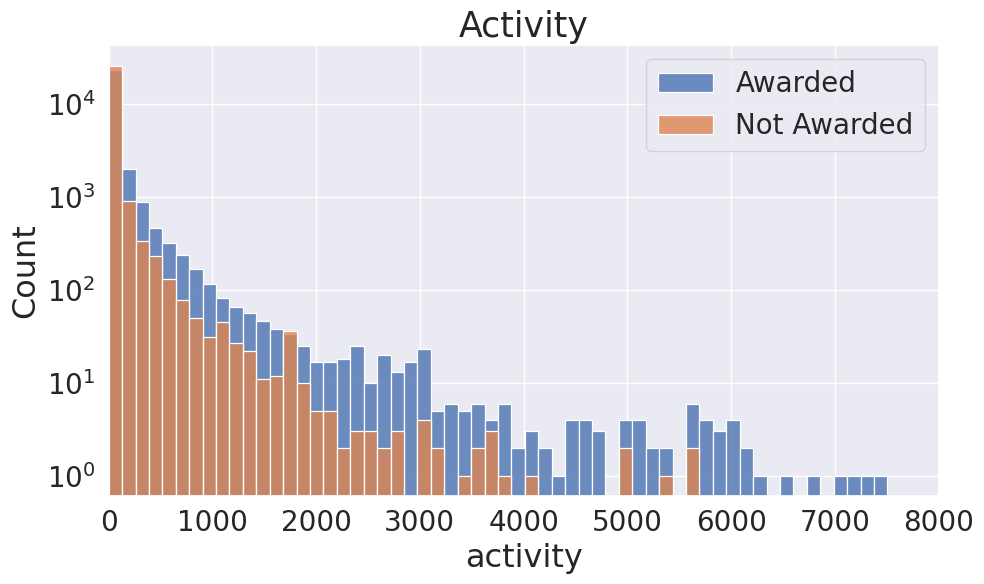

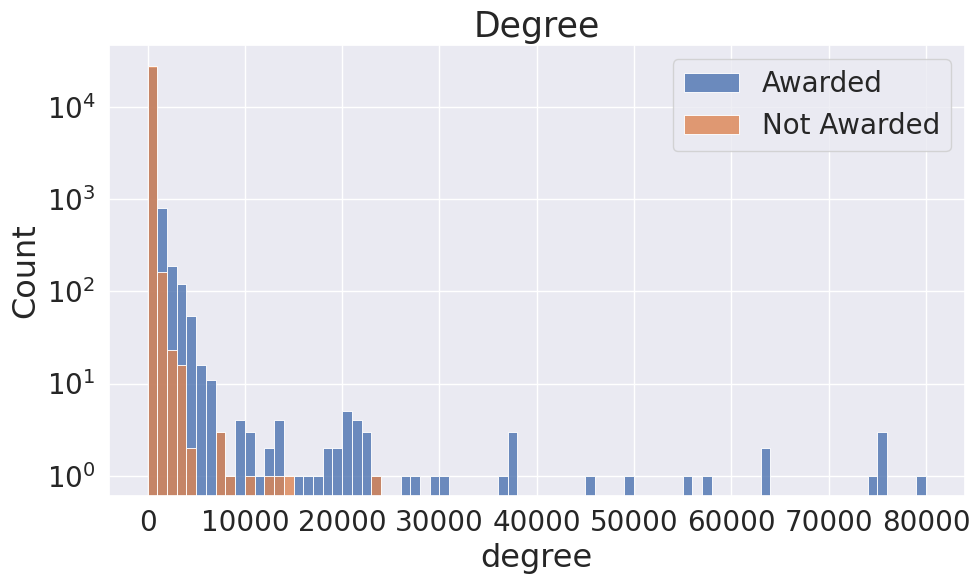

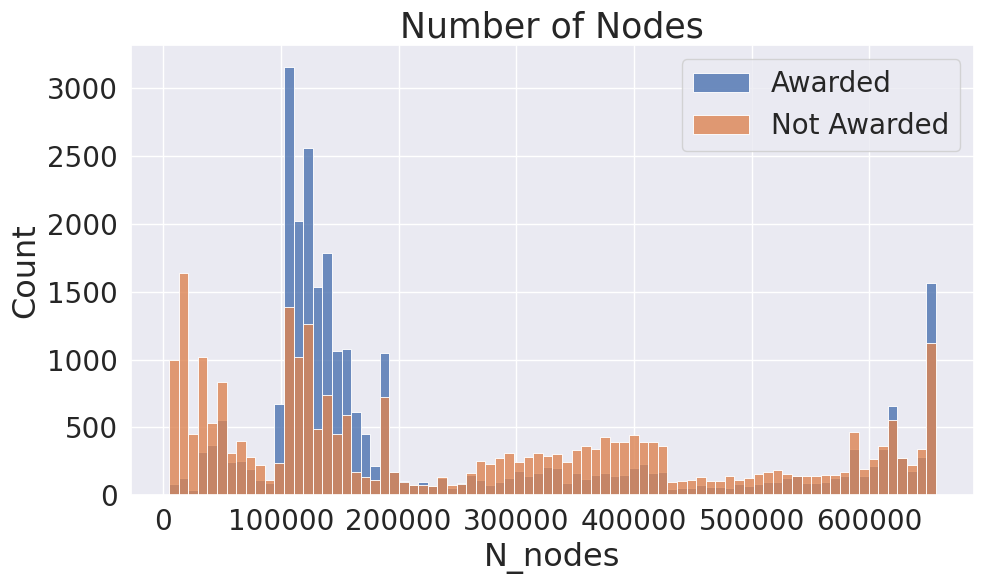

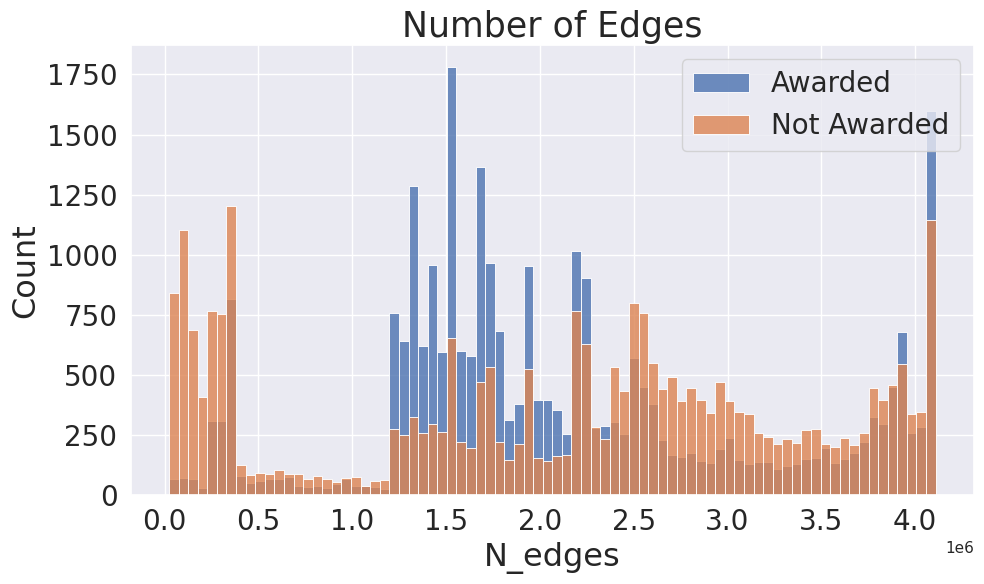

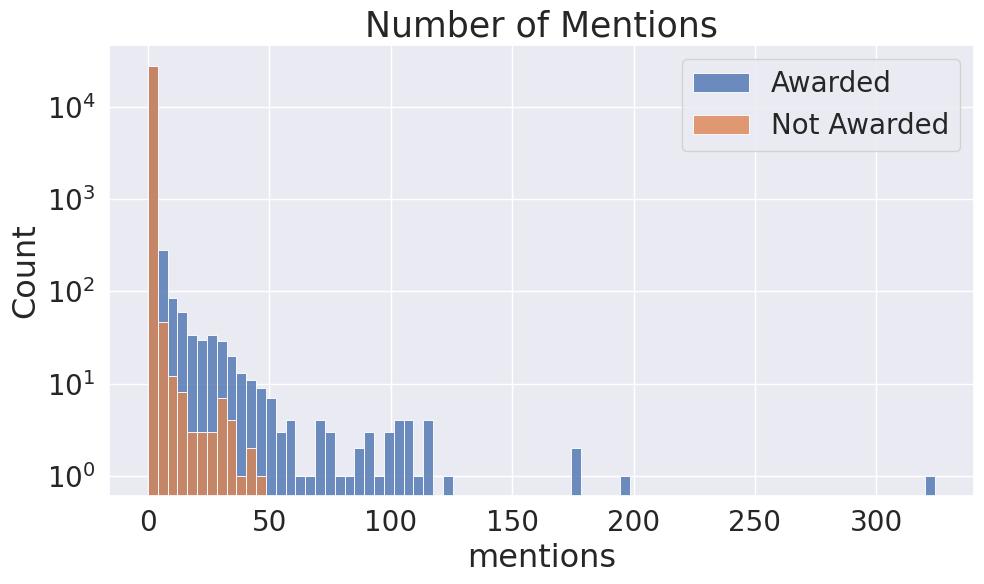

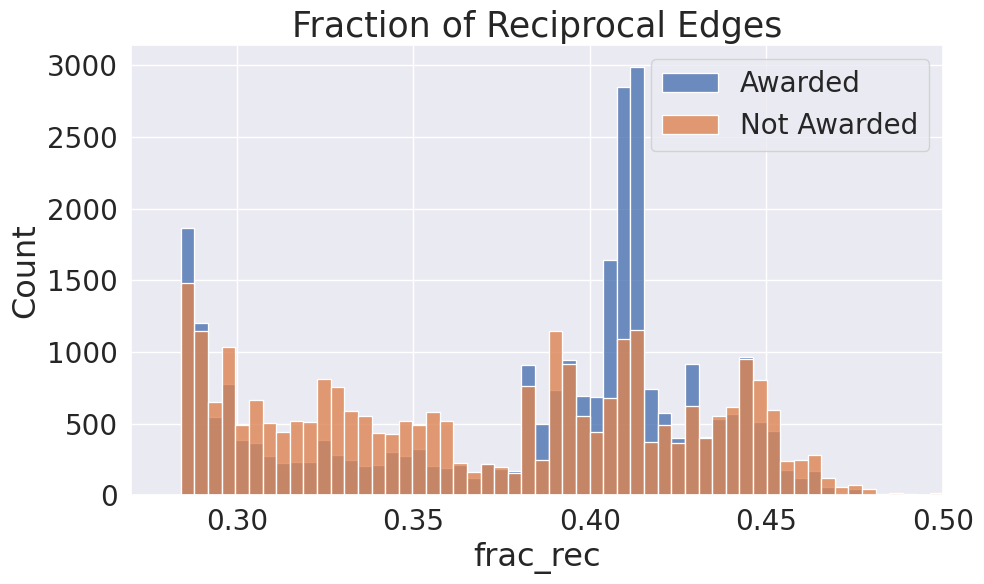

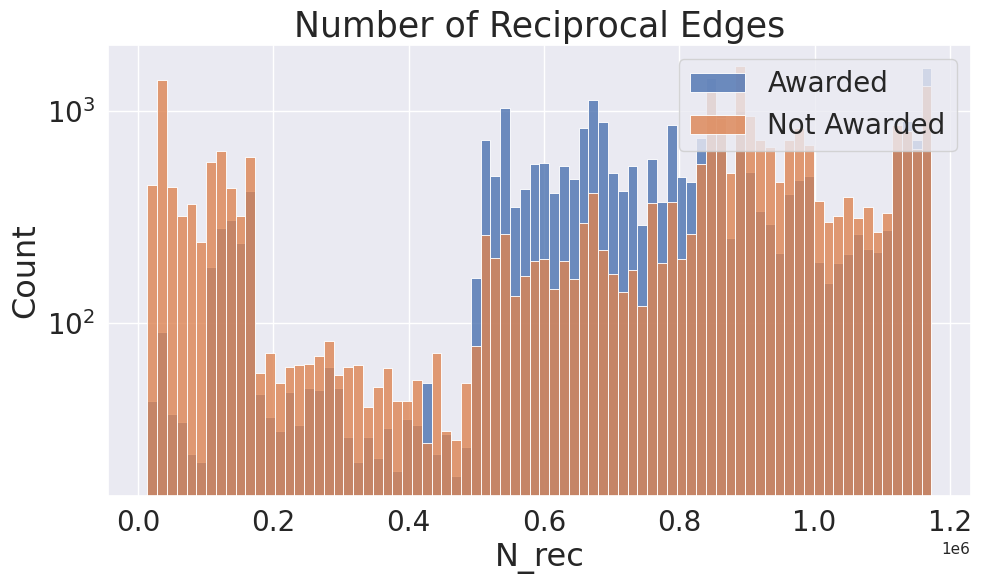

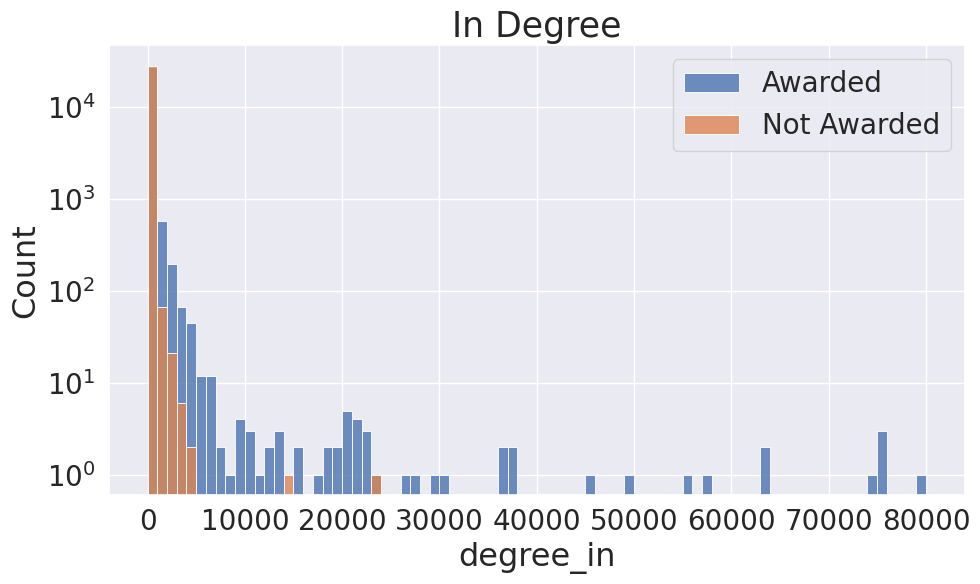

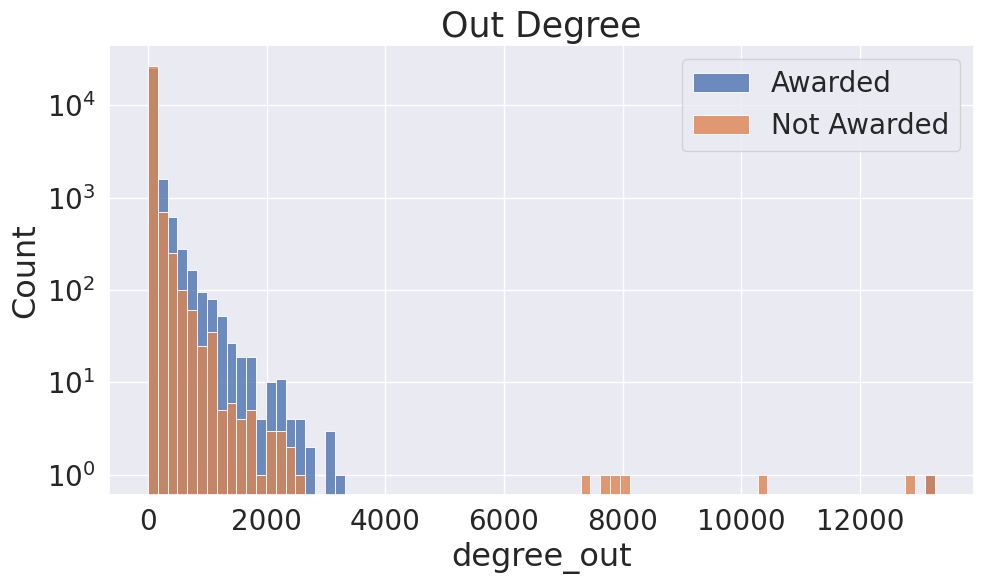

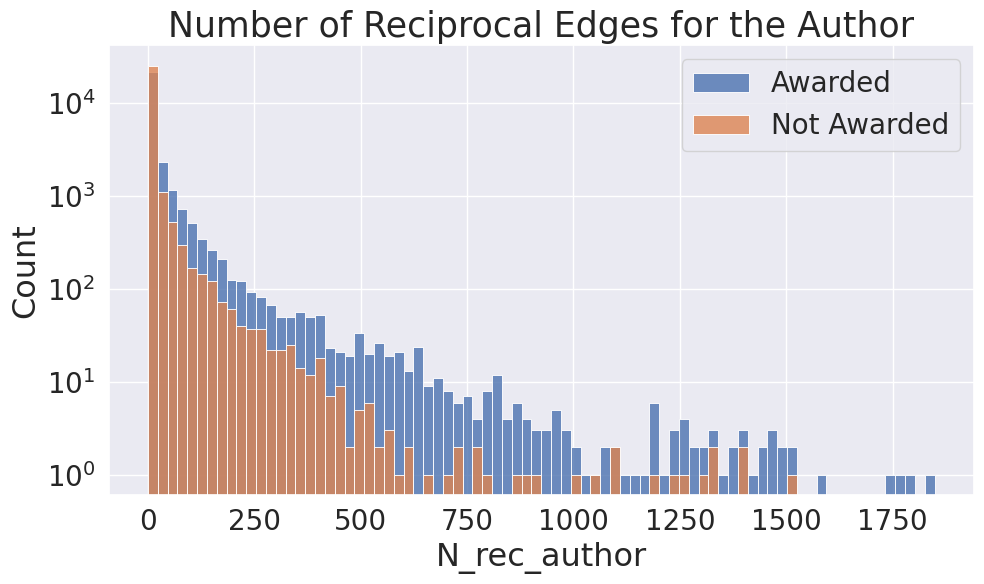

In [6]:
features = ['degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 
            'mentions','frac_rec','N_rec','degree_in','degree_out','N_rec_author']

log_features = ['degree_cen','close_cen', 'activity','degree','mentions','degree_in','degree_out','N_rec_author','N_rec']

for feat in features:
    plt.figure(figsize=(10, 6))

    bins=80
    if feat == 'degree_cen':
        plt.xlim(0,0.2)
        bins=200
    if feat == 'close_cen':
        plt.xlim(0,0.51)
    if feat == 'frac_rec':
        plt.xlim(0.27,0.5)
    # if feat == 'degree_out':
    #     plt.xlim(0,4000)
    # if feat == 'degree_in':
    #     plt.xlim(0,4000)
    if feat == 'activity':
        plt.xlim(0,8000)
        bins=200

    sns.histplot(data=df,x=feat,hue='awarded',
                # binwidth=0.01,
                bins=bins,
                palette=[sns.color_palette()[1],sns.color_palette()[0]],
                alpha=0.8)
    
    plt.title(feature_translate[feat],fontsize=25)
    plt.xlabel(feat,fontsize=23)
    plt.ylabel('Count',fontsize=23)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    if feat in log_features:
        plt.yscale('log')
    
    plt.legend(['Awarded','Not Awarded'],fontsize=20,loc='upper right')
    plt.tight_layout()
    # plt.savefig('/home/pelle/Master_Thesis/reports/figures/network_features/feature_'+str(feat)+'.png',dpi=300,bbox_inches='tight')
    plt.show()

In [7]:
features=['degree_cen','close_cen','activity',	'degree','N_nodes',
        'N_edges','mentions','frac_rec',	
        'degree_in','degree_out','N_rec_author','N_rec']

# KS test
from scipy.stats import ks_2samp
for feat in features:
    print(feat)
    print(ks_2samp(df.loc[df.awarded==1,feat],df.loc[df.awarded==0,feat],alternative='two-sided',mode='auto'))
    # print()

degree_cen
KstestResult(statistic=0.2892263633381999, pvalue=0.0)
close_cen
KstestResult(statistic=0.2893107841946995, pvalue=0.0)
activity
KstestResult(statistic=0.2806467875302201, pvalue=0.0)
degree
KstestResult(statistic=0.284778120249902, pvalue=0.0)
N_nodes
KstestResult(statistic=0.158072517008026, pvalue=1.572909811078777e-307)
N_edges
KstestResult(statistic=0.16280469727779506, pvalue=0.0)
mentions
KstestResult(statistic=0.12885202157861453, pvalue=4.185868811136256e-204)
frac_rec
KstestResult(statistic=0.1667883553833187, pvalue=0.0)
degree_in
KstestResult(statistic=0.28284113115930476, pvalue=0.0)
degree_out
KstestResult(statistic=0.2753556885000075, pvalue=0.0)
N_rec_author
KstestResult(statistic=0.27503854953682777, pvalue=0.0)
N_rec
KstestResult(statistic=0.16258519345245, pvalue=0.0)


In [10]:
# Kullback–Leibler divergence
from scipy.stats import entropy
for feat in features:
    print(feat)
    print(entropy(df.loc[df.awarded==1,feat].sample(2800),df.loc[df.awarded==0,feat].sample(2800)))
    # print()

degree_cen
inf
close_cen
inf
activity
inf
degree
inf
N_nodes
0.7493422589970372
N_edges
0.5437791347484616
mentions
inf
frac_rec
0.022317114379352156
degree_in
inf
degree_out
inf
N_rec_author
inf
N_rec
0.3865603184772921
